In [83]:
using Pkg
Pkg.activate(".")                 
# Pkg.update()     

using ControlSystems
using LinearAlgebra
using Plots

default(linewidth=4, framestyle=:axes, grid=true,
legendfontsize = 14,
tickfontsize=14)

# Skogestad tuning of individual loops

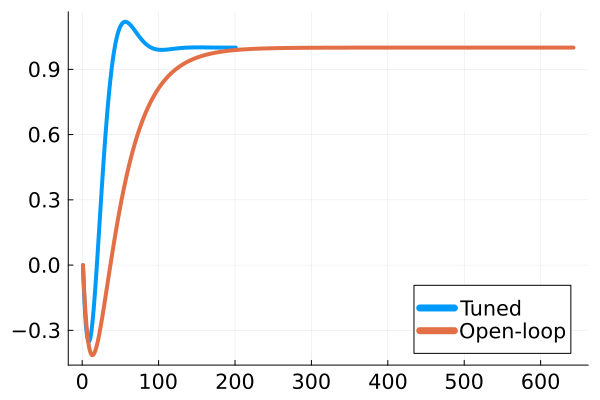

In [84]:
s = tf("s")

G11 = 1.0 / (s + 1)
G12 = 2.0 / (s + 3)
G21 = 1.0 / (s + 1)
G22 = 1.0 / (s + 1)

G = [G11 G12; G21 G22]
D = [3 -2; -3 3]
# Q = G*D


Q11 = (1-s)*3/((s+1)*(s+3))
Q12 = 4*s/((s+1)*(s+3))
Q22 = 1/(s+1)
Q = [Q11 Q12; 0.0 Q22]
Q_ind = [Q11 0.0; 0.0 Q22]


tc = 1.0 # use Skogestad tuning rules where the unstable zero is treated as delay
Kc = 1/(tc + 1.0)
tI = min(1, 4*(tc+1.0))
tD = 0 # use θ/2 
C1 = Kc*((tI*s+1)/(tI*s))*(tD*s + 1)

C2 = (1/0.5)*((s+1)/s)


C = [C1 0;0 C2]


plot([step(feedback(Q11*C1)).y', step(Q11).y'], labels=["Tuned" "Open-loop"])

In [85]:
# H_ind = ss(Q_ind*C)
CL_ind = feedback(ss(Q_ind*C));

ts = 0.01
t  = 0:ts:40
r(x,t) = [t ≥ 0.0; t ≥ 20]
y,t,_,_ = lsim(CL_ind, r, t)
plot(t,y', lw=4, xlabel="Time", ylabel="Output")
hline!([1], color=:grey, linestyle=:dash, lw=2, label="")
savefig("./figs/independent_loops.png")
savefig("./figs/independent_loops.pdf")

"/Users/nplawrence/Library/CloudStorage/OneDrive-UBC/Research/code/RL-MPC-tutorial/code/PID_LQR/figs/independent_loops.pdf"

In [86]:
# H = ss(Q*C)
CL = feedback(ss(Q*C));
t  = 0:ts:50

d1 = [0.0; 0.25]
d(t) = d1.*(41.0>=t>=40.0)
r(x,t) = [t ≥ 0.0; t ≥ 20] .+ d(t)

y,t,_,_ = lsim(CL, r, t)
plot(t,y', lw=4, xlabel="Time", ylabel="Output")
hline!([1], color=:grey, linestyle=:dash, lw=2, label="")
savefig("./figs/coupled_loop.png")
savefig("./figs/coupled_loop.pdf")

"/Users/nplawrence/Library/CloudStorage/OneDrive-UBC/Research/code/RL-MPC-tutorial/code/PID_LQR/figs/coupled_loop.pdf"

# Here's what you get if you're Karl Astrom

In [87]:
kp1, ki1 = 0.245, 0.248
kp2, ki2 = -0.452, 0.075
C1 = pid(kp1, ki1, form=:parallel)
C2 = pid(kp2, ki2, form=:parallel)

C = [C1 0;0 C2]

F = [pid(0.0, ki1, form=:parallel) 0.0; 0.0 pid(0.0, ki2, form=:parallel)]

# Ci = [pid(0.0, ki1, form=:parallel) 0.0; 0.0 pid(0.0, ki2, form=:parallel)]

CL = feedback(ss(Q*C))
CL_weighted = feedback(ss(Q), ss(C))*F

t  = 0:ts:80
r(x,t) = [t ≥ 0.0; t ≥ 40] 

y_weighted,_,_,_ = lsim(CL_weighted, r, t)
y,_,_,_ = lsim(CL, r, t)

plt = plot(layout=(2,1),yticks = -0.50:0.5:1.25,)
plot!(plt[1], t, y', title="Good", ylabel="Output")
hline!([1], color=:grey, linestyle=:dash, lw=2, label="")

plot!(plt[2], t, y_weighted', title="Better", labels=["y1" "y2"], ylabel="Output", xlabel="Time")
hline!(plt[2],[1], color=:grey, linestyle=:dash, lw=2, label="")


savefig("./figs/astrom_pid.png")
savefig("./figs/astrom_pid.pdf")

"/Users/nplawrence/Library/CloudStorage/OneDrive-UBC/Research/code/RL-MPC-tutorial/code/PID_LQR/figs/astrom_pid.pdf"

# LQR to automatically account for interactions

In [88]:
using LinearAlgebra
Qd = c2d(ss(Q),ts)

A, B, C = Qd.A, Qd.B, Qd.C
K = lqr(Discrete, A,B,1*I,I)


d1 = 0.25*randn(size(B,2))
d1[1,1] = 0.0 # just to illustrate the coupling in the systems
d2 = 0.5*randn(size(B,2))

d(t) = d1.*(16.0>=t>=15.0) .+ d2.*(31.0>=t>=30.0)
ux(x,t)  = -K*x .+ d(t)  # Form control law (u is a function of t and x), a constant input disturbance is affecting the system from t≧2.5
# ux(x,t) = -K*x # Form control law,

t=0:ts:50
x0 = rand(size(A,1)) .- 0.50
# x0 = [0.61, 0.95, 0.66, 0.61, 0.81]
x0 = [-0.02, -0.37, 0.46, 0.39, 0.37]
y, t, x, uout = lsim(Qd,ux,t,x0=x0)

plt = plot(layout=(2,1))
plot!(plt[1], t, uout', seriestype = :step, labels=["u1" "u2"], yticks = -1.5:0.5:1.5,legend=:bottomright, ylabel="Input")
# plot!(plt[1], t, t->norm(d(t)))
# hline!([-1,1])
plot!(plt, t, y', seriestype = :step, subplot=2, labels=["y1" "y2"], yticks = -3.0:0.5:3.0,legend=:bottomright, ylabel="Output", xlabel="Time")
# hline!([-5,5], subplot=2)

savefig("./figs/lqr_disturbance.png")
savefig("./figs/lqr_disturbance.pdf")

"/Users/nplawrence/Library/CloudStorage/OneDrive-UBC/Research/code/RL-MPC-tutorial/code/PID_LQR/figs/lqr_disturbance.pdf"

# LQR under constraints?

In [89]:
A = [1.0 1.0; 0.0 1.0]
B = [1.0; 0.5]
C = [1.0 0.0]
sys = ss(A,  B,  C, 0, 1.0)
K = lqr(Discrete, A, B, I, I)

ux(x,t) = clamp.(-K*(x ), -1.0, 1.0) # Form control law,
u_ideal(x,t) = -K*x

t=0:100
x0 = randn(size(A,1)) # random initial state
# x0 = -1*[-4.0, -4.0] # state starts infeasible
x0 = -3*[1.5, -1.0] # state that starts feasible then violates constraints later
y, t, x, uout = lsim(sys,ux,t,x0=x0)
_, _, x_ideal, uout_ideal = lsim(sys,u_ideal,t,x0=x0)

using Plots
using Plots.PlotMeasures
colors = palette(:default)

plt = plot(layout=(2,1), legend = (0.4, 2.65), legendcolumns=2)
plot!(plt, t, uout_ideal', seriestype = :step, label="", ylabel="Input", color=:grey, lw=3, top_margin = 60px)
plot!(plt, t, uout', seriestype = :step, label="", ylabel="Input", color=colors[1])
hline!([-1,1], label="", color=colors[2], lw=2)
plot!(plt[2], t, x_ideal', seriestype = :step, subplot=2, label=["" "Ideal"], ylabel="States", xlabel="Time", color=:grey, lw=3)
plot!(plt[2], t, x', seriestype = :step, subplot=2, label=["" "Constrained"], ylabel="States", xlabel="Time", color=colors[1])

hline!([-5,5], subplot=2, label="", color=colors[2], lw=2)

savefig("./figs/lqr_constrained_later.png")
savefig("./figs/lqr_constrained_later.pdf")


"/Users/nplawrence/Library/CloudStorage/OneDrive-UBC/Research/code/RL-MPC-tutorial/code/PID_LQR/figs/lqr_constrained_later.pdf"